In [73]:
# based on https://wroscoe.github.io/keras-lane-following-autopilot.html

import os
import urllib.request
import pickle
import numpy as np
import cv2

%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow, imread

In [137]:
test = []
if os.path.isfile('../lobby2/img/img0900.jpeg'): 
    img = cv2.imread('../lobby2/img/img0000.jpeg')
    test.append(img)
    test.append(cv2.imread('../lobby2/img/img0001.jpeg'))
test = np.array(test)
print(test.shape)

(0,)


# Get Data

X shape: (825, 128, 160, 3)
y shape:  (825,)


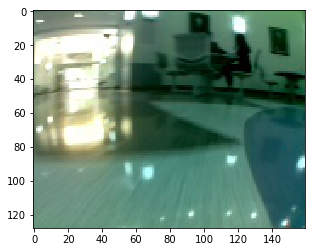

In [198]:
import csv

# checkpoints:
# [0:4000] -> Closed loop driving
# 13606 total
raw_X = []
raw_y = []
data_path = '../lobby2'
with open(data_path + '/capture_log.csv', 'r') as f:
    reader = csv.reader(f)
    iterreader = iter(reader)
    next(iterreader)
    count = 0
    for row in iterreader:
        path = data_path + row[0][1:]
        img = cv2.imread(path)
        if img is not None:
            raw_X.append(img) 
            raw_y.append(1000*float(row[2]))
            count += 1
    raw_X = np.array(raw_X)
    raw_y = np.array(raw_y)
    print('X shape:', raw_X.shape)
    print('y shape: ', raw_y.shape)
    imshow(raw_X[800])

In [199]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]

shuffled_X, shuffled_y = shuffle_data(raw_X, raw_y)

In [200]:
test_cutoff = int(len(raw_X) * 0.8)
val_cutoff = test_cutoff + int(len(raw_X) * 0.1)

train_X, train_y = shuffled_X[:test_cutoff], shuffled_y[:test_cutoff]
val_X, val_y = shuffled_X[test_cutoff:val_cutoff], shuffled_y[test_cutoff:val_cutoff]
test_X, test_y = shuffled_X[val_cutoff:], shuffled_y[val_cutoff:]

print(len(train_X))
print(len(val_X))
print(len(test_X))

660
82
83


In [201]:
# flip images to remove steering bias
X_flipped = np.array([np.fliplr(i) for i in train_X])
y_flipped = np.array([-i for i in train_y])
train_X = np.concatenate([train_X, X_flipped])
train_y = np.concatenate([train_y, y_flipped])
len(train_X)

1320

In [202]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D

# Model used by William Roscoe for the Donkey SDC

In [203]:
model = Sequential()
model.add(Convolution2D(8, (3,3), input_shape=(128, 160, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('linear'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 158, 8)       224       
_________________________________________________________________
activation_41 (Activation)   (None, 126, 158, 8)       0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 79, 8)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 61, 77, 16)        1168      
_________________________________________________________________
activation_42 (Activation)   (None, 61, 77, 16)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 30, 38, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 36, 32)        4640      
__________

# Train

In [204]:
from keras import callbacks
model_path = os.getcwd() + '/models/model.hdf5'
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [205]:
model.fit(train_X, train_y, batch_size=16, epochs=8, validation_data=(val_X, val_y), callbacks=callbacks_list)

Train on 1320 samples, validate on 82 samples
Epoch 1/8
1320/1320 [==============================] - 16s - loss: 31832.2499 - val_loss: 2940.7466
Epoch 2/8
1320/1320 [==============================] - 15s - loss: 2585.0703 - val_loss: 2114.0969
Epoch 3/8
1320/1320 [==============================] - 15s - loss: 1908.4814 - val_loss: 2073.8104
Epoch 4/8
1320/1320 [==============================] - 15s - loss: 1678.5666 - val_loss: 1671.0518
Epoch 5/8
1320/1320 [==============================] - 15s - loss: 1427.8161 - val_loss: 1504.4481
Epoch 6/8
1320/1320 [==============================] - 15s - loss: 1317.1603 - val_loss: 1219.3334
Epoch 7/8
1320/1320 [==============================] - 15s - loss: 1235.3989 - val_loss: 1684.7786
Epoch 8/8
1320/1320 [==============================] - 15s - loss: 1069.2661 - val_loss: 1700.0533


# Evaluate

In [206]:
import pandas as pd
from keras.models import load_model
model = load_model(model_path)

# Test Data

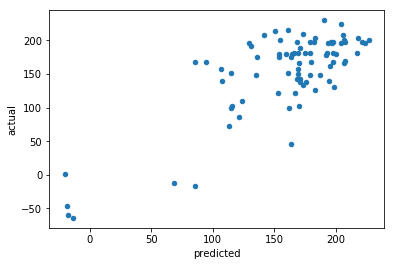

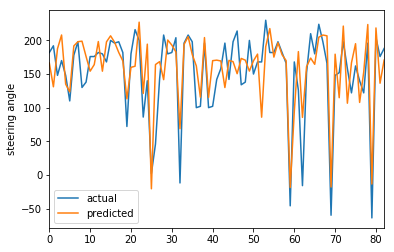

In [207]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape((pred_y.shape[0],))
df = pd.DataFrame({'predicted':pred_y, 'actual':test_y})
ax = df.plot.scatter('predicted', 'actual')
ax2 = pd.DataFrame({'predicted':pred_y, 'actual':test_y}).plot()
ax2.set_ylabel('steering angle')

# Training Data

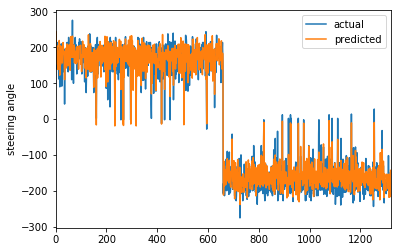

In [209]:
pred_y_2 = model.predict(train_X)
pred_y_2 = pred_y_2.reshape((pred_y_2.shape[0],))

ax = pd.DataFrame({'predicted':pred_y_2, 'actual':train_y}).plot()
ax.set_ylabel('steering angle')